In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [2]:
# Set paths
data_dir = "C:/Users/Otinwa Ayomide/Downloads/Dissertation/Banana Ripeness Classification.v4-augmented3x-modifiedclasses.folder"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/valid"
test_dir = f"{data_dir}/test"

# Parameters
img_size = (224, 224)
batch_size = 32

# Load dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)


Found 20000 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.
Found 800 files belonging to 4 classes.


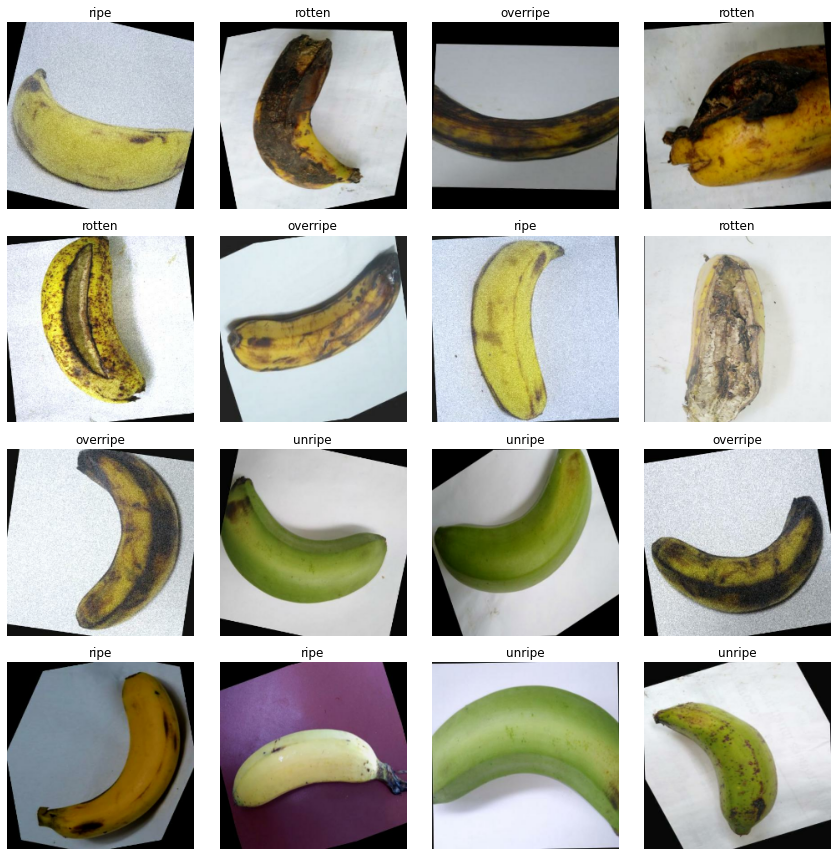

In [4]:
images, labels = next(iter(train_dataset))

# Get class names
class_names = train_dataset.class_names

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

# Show 4 images per class
shown = {label: 0 for label in range(len(class_names))}
count = 0

for i in range(len(images)):
    label = int(labels[i].numpy())
    if shown[label] < 4:
        ax = axes[count]
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[label])
        ax.axis('off')
        shown[label] += 1
        count += 1
    if count == 16:
        break

plt.tight_layout()
plt.show()

In [133]:
base_model = keras.applications.ResNet152(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False) 
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

# Added Layers
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(64, activation='relu')(x)


# Final Output Layer
outputs = keras.layers.Dense(4)(x) 

model = keras.Model(inputs, outputs)
model.summary()



Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_24  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_24 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_288 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 256)               0  

In [134]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )


early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


history = model.fit(train_dataset, epochs = 30, validation_data=val_dataset, callbacks = early_stopping)

Epoch 1/30
625/625 [==============================] - 1874s 3s/step - loss: 0.2461 - sparse_categorical_accuracy: 0.9161 - val_loss: 0.1227 - val_sparse_categorical_accuracy: 0.9675
Epoch 2/30
625/625 [==============================] - 1844s 3s/step - loss: 0.1346 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.1046 - val_sparse_categorical_accuracy: 0.9669
Epoch 3/30
625/625 [==============================] - 1831s 3s/step - loss: 0.1152 - sparse_categorical_accuracy: 0.9615 - val_loss: 0.0972 - val_sparse_categorical_accuracy: 0.9719
Epoch 4/30
625/625 [==============================] - 1835s 3s/step - loss: 0.1040 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.0836 - val_sparse_categorical_accuracy: 0.9787
Epoch 5/30
625/625 [==============================] - 1833s 3s/step - loss: 0.0945 - sparse_categorical_accuracy: 0.9678 - val_loss: 0.0927 - val_sparse_categorical_accuracy: 0.9737
Epoch 6/30
625/625 [==============================] - 1829s 3s/step - loss: 0.0912 - spars

In [5]:
result = model.evaluate(test_dataset)
print(f"Accuracy of Teacher model {result[1]*100:.2f}%")

25/25 [==============================] - 113s 4s/step - loss: 0.1395 - sparse_categorical_accuracy: 0.9775
Accuracy of Teacher model 97.75%


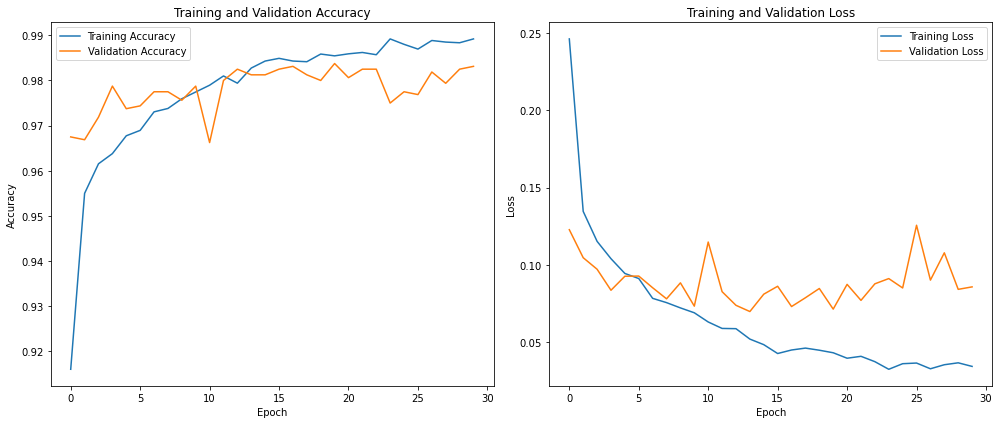

In [135]:
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 3s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.98      0.97       200
           2       0.98      0.96      0.97       200
           3       0.98      0.98      0.98       200

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



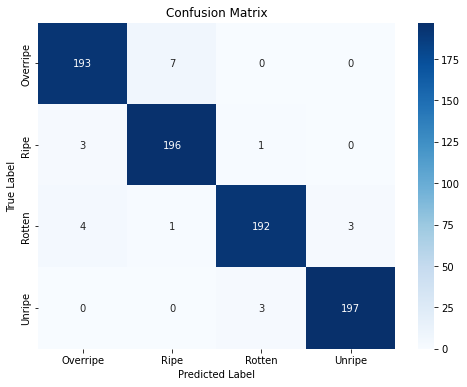

In [138]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    logits = model.predict(images)
    preds = tf.argmax(logits, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


target_names = ['Overripe', 'Ripe', 'Rotten', 'Unripe']  


print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [4]:
# # model.save('resnet152_model.h5')
# model = load_model('resnet152_model.h5') 

In [118]:
# Knowledge Distillation class
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [119]:
from tensorflow.keras import layers, models, Input

def basic_block(x, filters, stride=1, downsample=False):
    identity = x

    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

def build_resnet10(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Block 1
    x = basic_block(x, 64)

    # Block 2
    x = basic_block(x, 128, stride=2, downsample=True)

    # Block 3
    x = basic_block(x, 192, stride=2, downsample=True)

    # Block 4
    x = basic_block(x, 256, stride=2, downsample=True)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes)(x)

    model = models.Model(inputs, outputs)
    return model

# Create the student model
student = build_resnet10()
student.summary()


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_276 (Conv2D)            (None, 112, 112, 64  9408        ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_276 (Batch  (None, 112, 112, 64  256        ['conv2d_276[0][0]']             
 Normalization)                 )                                                          

                                                                                                  
 re_lu_214 (ReLU)               (None, 7, 7, 256)    0           ['batch_normalization_285[0][0]']
                                                                                                  
 conv2d_286 (Conv2D)            (None, 7, 7, 256)    589824      ['re_lu_214[0][0]']              
                                                                                                  
 conv2d_287 (Conv2D)            (None, 7, 7, 256)    49152       ['re_lu_213[0][0]']              
                                                                                                  
 batch_normalization_286 (Batch  (None, 7, 7, 256)   1024        ['conv2d_286[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

In [120]:
distiller = Distiller(student=student, teacher=model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.05,
    temperature=2,

)
   
history2 = distiller.fit(train_dataset, validation_data = val_dataset, epochs=15)


Epoch 1/15
625/625 [==============================] - 2427s 4s/step - sparse_categorical_accuracy: 0.8729 - student_loss: 0.4190 - distillation_loss: 0.3135 - val_sparse_categorical_accuracy: 0.8238 - val_student_loss: 1.8033
Epoch 2/15
625/625 [==============================] - 2420s 4s/step - sparse_categorical_accuracy: 0.9158 - student_loss: 0.2892 - distillation_loss: 0.2077 - val_sparse_categorical_accuracy: 0.5519 - val_student_loss: 0.5557
Epoch 3/15
625/625 [==============================] - 2373s 4s/step - sparse_categorical_accuracy: 0.9330 - student_loss: 0.2319 - distillation_loss: 0.1631 - val_sparse_categorical_accuracy: 0.8306 - val_student_loss: 0.5698
Epoch 4/15
625/625 [==============================] - 2313s 4s/step - sparse_categorical_accuracy: 0.9375 - student_loss: 0.2153 - distillation_loss: 0.1518 - val_sparse_categorical_accuracy: 0.8200 - val_student_loss: 0.1876
Epoch 5/15
625/625 [==============================] - 2293s 4s/step - sparse_categorical_accurac

In [127]:
print(history2.history.keys())


dict_keys(['sparse_categorical_accuracy', 'student_loss', 'distillation_loss', 'val_sparse_categorical_accuracy', 'val_student_loss'])


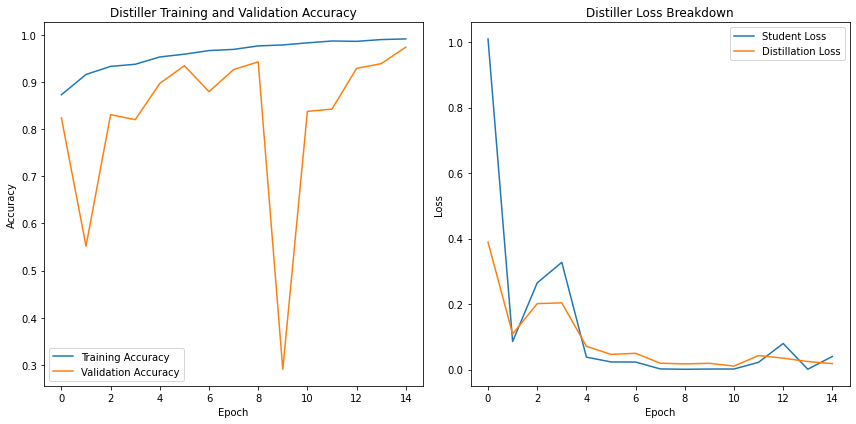

In [140]:
import matplotlib.pyplot as plt

history = history2.history  

plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Distiller Training and Validation Accuracy')

# Plot training and Ditillation loss
plt.subplot(1, 2, 2)
plt.plot(history['student_loss'], label='Student Loss')
plt.plot(history['distillation_loss'], label='Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Distiller Loss Breakdown')

plt.tight_layout()
plt.show()


In [129]:
result2 = distiller.evaluate(test_dataset, return_dict=True)
print(f"Accuracy of student model: {result2['sparse_categorical_accuracy']*100:.2f}%")


25/25 [==============================] - 5s 176ms/step - sparse_categorical_accuracy: 0.9712 - student_loss: 0.1163
Accuracy of student model: 97.12%


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       200
           1       0.98      0.95      0.97       200
           2       0.96      0.96      0.96       200
           3       0.98      0.98      0.98       200

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



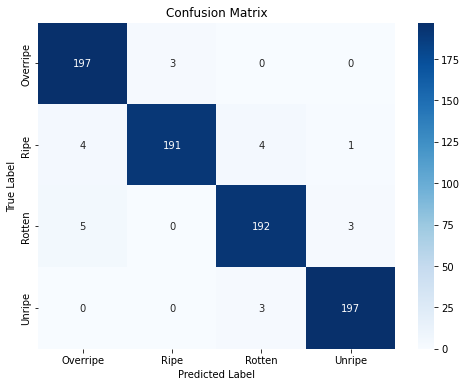

In [130]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Forward pass through student model
    logits = student(images, training=False)
    preds = tf.argmax(logits, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = ['Overripe', 'Ripe', 'Rotten', 'Unripe']

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [132]:
student.save('resnet10_distilled_model.h5')